<a href="https://colab.research.google.com/github/eccho03/datamining_project_clothes/blob/main/A_priori.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

In [3]:
# CSV 파일 읽기
data = pd.read_csv('https://raw.githubusercontent.com/eccho03/datamining_project_clothes/refs/heads/main/size_selection_info.csv')

# 데이터 확인
print(data.head())

   weight   age  height size
0      62  28.0  172.72   XL
1      59  36.0  167.64    L
2      61  34.0  165.10    M
3      65  27.0  175.26    L
4      62  45.0  172.72    M


In [4]:
# 키와 몸무게를 숫자형으로 변환
data['height'] = pd.to_numeric(data['height'], errors='coerce')
data['weight'] = pd.to_numeric(data['weight'], errors='coerce')

# 결측값 제거
data.dropna(subset=['height', 'weight'], inplace=True)

In [5]:
# 키 범주화
bins_height = [0, 160, 170, 180, float('inf')]
labels_height = ['height_less_160', 'height_less_170', 'height_less_180', 'height_over_180']
data['height_range'] = pd.cut(data['height'], bins=bins_height, labels=labels_height, right=False)

# 몸무게 범주화
bins_weight = [0, 50, 60, 70, 80, float('inf')]
labels_weight = ['weight_less_50', 'weight_less_60', 'weight_less_70', 'weight_less_80', 'weight_over_80']
data['weight_range'] = pd.cut(data['weight'], bins=bins_weight, labels=labels_weight, right=False)

# 사이즈 범주화
size_mapping = {
    'XXXS': 'XS', 'XXS': 'XS', 'XS': 'XS',
    'S': 'S',
    'M': 'M',
    'L': 'L',
    'XL': 'XL', 'XXL': 'XL', 'XXXL': 'XL'
}
data['size_range'] = data['size'].replace(size_mapping)
data['size_range'] = data['size'].replace(size_mapping).fillna('Unknown') # 예외 처리

# 결과 확인
print(data.head())

   weight   age  height size     height_range    weight_range size_range
0      62  28.0  172.72   XL  height_less_180  weight_less_70         XL
1      59  36.0  167.64    L  height_less_170  weight_less_60          L
2      61  34.0  165.10    M  height_less_170  weight_less_70          M
3      65  27.0  175.26    L  height_less_180  weight_less_70          L
4      62  45.0  172.72    M  height_less_180  weight_less_70          M


In [6]:
# 범주화된 데이터를 트랜잭션으로 변환
transactions = data[['height_range', 'weight_range', 'size']].apply(lambda x: set(x), axis=1).tolist()

# 트랜잭션 데이터를 이진화
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
encoded_df = pd.DataFrame(te_ary, columns=te.columns_)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


----------------frequent itemsets-----------------
     support                              itemsets
0   0.146804                                   (L)
1   0.248216                                   (M)
2   0.183193                                   (S)
3   0.159668                                  (XL)
4   0.083130                                 (XXS)
5   0.178411                                (XXXL)
6   0.154919                     (height_less_160)
7   0.516842                     (height_less_170)
8   0.303122                     (height_less_180)
9   0.403672                      (weight_less_60)
10  0.338163                      (weight_less_70)
11  0.135079                      (weight_less_80)
12  0.097116                   (weight_less_70, L)
13  0.135540                  (height_less_170, M)
14  0.156494                   (M, weight_less_60)
15  0.084093                   (weight_less_70, M)
16  0.101504                  (height_less_170, S)
17  0.142022                   

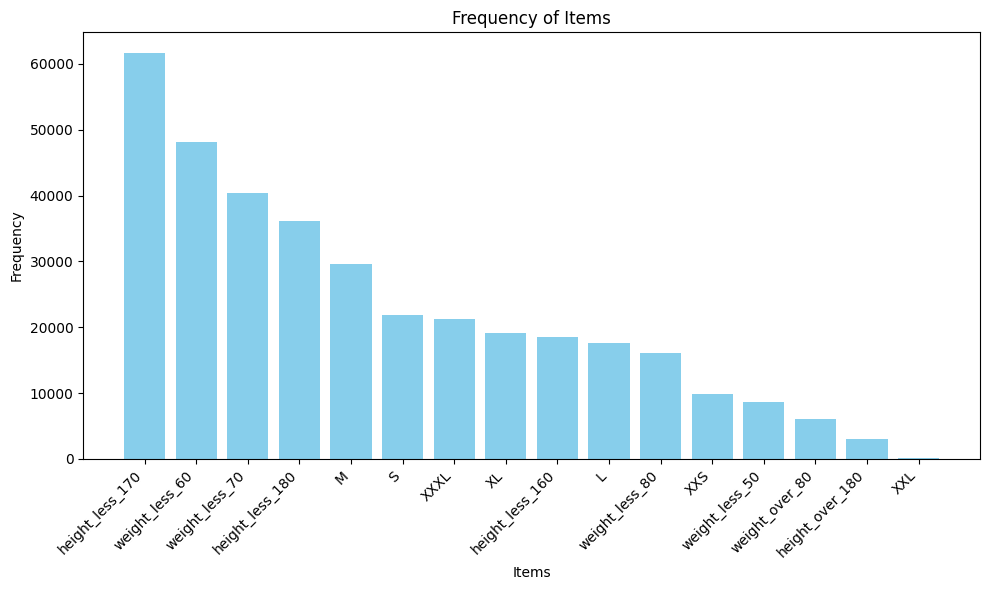

In [10]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt

frequent_itemsets = apriori(encoded_df, min_support=0.08, use_colnames=True)
print("----------------frequent itemsets-----------------")
print(frequent_itemsets)


# 각 항목별 빈도 계산
item_frequencies = encoded_df.sum().sort_values(ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(item_frequencies.index, item_frequencies.values, color='skyblue')
plt.xlabel('Items', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.title('Frequency of Items', fontsize=12)
plt.xticks(rotation=45, ha='right')  # 항목 이름이 길 경우
plt.tight_layout()
plt.show()

In [13]:
frequent_itemsets['num_itemsets'] = len(frequent_itemsets)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.08, num_itemsets=frequent_itemsets['num_itemsets'])

print("------------------------------연관 규칙----------------------------\n")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

------------------------------연관 규칙----------------------------

                          antecedents                        consequents  \
0                    (weight_less_70)                                (L)   
1                                 (L)                   (weight_less_70)   
2                   (height_less_170)                                (M)   
3                                 (M)                  (height_less_170)   
4                                 (M)                   (weight_less_60)   
5                    (weight_less_60)                                (M)   
6                    (weight_less_70)                                (M)   
7                                 (M)                   (weight_less_70)   
8                   (height_less_170)                                (S)   
9                                 (S)                  (height_less_170)   
10                                (S)                   (weight_less_60)   
11                   (w

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
height_to_size_rules = rules[
    (rules['antecedents'].apply(lambda x: any(item.startswith('height') for item in x))) &
    (rules['consequents'].apply(lambda x: any(item in ['XS', 'S', 'M', 'L', 'XL'] for item in x)))
]

print("-------------------------키 -> 사이즈 연관 규칙-----------------------")
print(height_to_size_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

-------------------------키 -> 사이즈 연관 규칙-----------------------
                          antecedents          consequents   support  \
2                   (height_less_170)                  (M)  0.135540   
8                   (height_less_170)                  (S)  0.101504   
27  (height_less_170, weight_less_60)                  (M)  0.093607   
29                  (height_less_170)  (M, weight_less_60)  0.093607   
33  (height_less_170, weight_less_60)                  (S)  0.084185   
35                  (height_less_170)  (S, weight_less_60)  0.084185   

    confidence      lift  
2     0.262246  1.056524  
8     0.196393  1.072054  
27    0.385919  1.554772  
29    0.181113  1.157314  
33    0.347075  1.894587  
35    0.162883  1.146886  


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
weight_to_size_rules = rules[
    (rules['antecedents'].apply(lambda x: any(item.startswith('weight_') for item in x))) &
    (rules['consequents'].apply(lambda x: any(item in ['XS', 'S', 'M', 'L', 'XL'] for item in x)))
]

print("-------------------------몸무게 -> 사이즈 규칙-------------------------")
print(weight_to_size_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

-------------------------몸무게 -> 사이즈 규칙-------------------------
                          antecedents           consequents   support  \
0                    (weight_less_70)                   (L)  0.097116   
5                    (weight_less_60)                   (M)  0.156494   
6                    (weight_less_70)                   (M)  0.084093   
11                   (weight_less_60)                   (S)  0.142022   
13                   (weight_less_70)                  (XL)  0.101647   
27  (height_less_170, weight_less_60)                   (M)  0.093607   
31                   (weight_less_60)  (height_less_170, M)  0.093607   
33  (height_less_170, weight_less_60)                   (S)  0.084185   
37                   (weight_less_60)  (height_less_170, S)  0.084185   

    confidence      lift  
0     0.287186  1.956254  
5     0.387676  1.561850  
6     0.248675  1.001849  
11    0.351826  1.920517  
13    0.300584  1.882559  
27    0.385919  1.554772  
31    0.231888  

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
# 키, 몸무게 -> 사이즈 연관 규칙
height_weight_to_size_rules = rules[
    (rules['antecedents'].apply(lambda x: any(item.startswith('height_') or item.startswith('weight_') for item in x))) &  # 키와 몸무게 관련 항목
    (rules['consequents'].apply(lambda x: any(item in ['XS', 'S', 'M', 'L', 'XL'] for item in x)))  # 사이즈 관련 항목
]

print("------------------------- (키, 몸무게) -> 사이즈 규칙-------------------------")
print(height_weight_to_size_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

------------------------- (키, 몸무게) -> 사이즈 규칙-------------------------
                          antecedents           consequents   support  \
0                    (weight_less_70)                   (L)  0.097116   
2                   (height_less_170)                   (M)  0.135540   
5                    (weight_less_60)                   (M)  0.156494   
6                    (weight_less_70)                   (M)  0.084093   
8                   (height_less_170)                   (S)  0.101504   
11                   (weight_less_60)                   (S)  0.142022   
13                   (weight_less_70)                  (XL)  0.101647   
27  (height_less_170, weight_less_60)                   (M)  0.093607   
29                  (height_less_170)   (M, weight_less_60)  0.093607   
31                   (weight_less_60)  (height_less_170, M)  0.093607   
33  (height_less_170, weight_less_60)                   (S)  0.084185   
35                  (height_less_170)   (S, weight_les

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
